In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import re

In [2]:
df_hits = pd.read_csv('df_hits_clean.csv')

In [3]:
df_sessions = pd.read_csv('df_sessions_clean.csv')

C:\Users\derna\AppData\Local\Temp\ipykernel_12476\2978817895.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sessions = pd.read_csv('df_sessions_clean.csv')


# Проверка гипотез

## 1. Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.

Гипотеза 1

Органический трафик не отличается от платного с точки зрения CR
(Conversion Rate) в целевые события.

H0 (нулевая гипотеза): CR в органическом и платном трафике одинаковый.

H1 (альтернатива): CR отличается.

Если p-value < 0.05 → различие статистически значимо

In [10]:
#Создадим колонку is_target, в которой укажем было ли совершено целевое действие(1-совершено, 0-не совершено)

In [12]:
target_events = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

df_hits['is_target'] = df_hits['event_action'].isin(target_events).astype(int)

In [13]:
df_hits['is_target'].value_counts(dropna=False)

is_target
0    15621562
1      104908
Name: count, dtype: int64

Добавим колонку traffic_type во фрейм sessions для определения типа трафика

In [18]:
#отдельно выносим строки с is_target=1
converted_sessions = df_hits.groupby('session_id')['is_target'].max().reset_index()

# Помечаем тип трафика: органический или платный
organic_mediums = ['organic', 'referral', '(none)']
df_sessions['traffic_type'] = df_sessions['utm_medium'].apply(
    lambda x: 'organic' if x in ['organic', 'referral', '(none)'] else ('paid' if x != 'other' else 'unknown'))

In [19]:
# Объединяем сессии с флагами конверсий
df_combined = pd.merge(df_sessions, converted_sessions, on='session_id', how='left')
df_combined['is_target'] = df_combined['is_target'].fillna(0).astype(int)

In [20]:
# Считаем CR по типу трафика
cr_by_traffic_type = df_combined.groupby('traffic_type')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

cr_by_traffic_type['conversion_rate'] = cr_by_traffic_type['conversions'] / cr_by_traffic_type['total_sessions']
print(cr_by_traffic_type)

  traffic_type  conversions  total_sessions  conversion_rate
0      organic        20812          515659         0.040360
1         paid        29502         1344383         0.021945


In [21]:
paid = df_combined[df_combined['traffic_type'] == 'paid']['is_target'].reset_index(drop=True)
organic = df_combined[df_combined['traffic_type'] == 'organic']['is_target'].reset_index(drop=True)

# количество значений paid и organic разное, возьмем минимальное значение длины, чтобы сделать две одинаковые выборки
min_len = min(len(paid), len(organic))

paid = paid[:min_len]
organic = organic[:min_len]

df_split = pd.DataFrame({
    'paid_is_target': paid,
    'organic_is_target': organic
})

In [22]:
#тест Шапиро-Уилка плохо работает на больших выборках. Применим Kolmogorov–Smirnov test 
ks_stat, ks_pval = kstest(df_split['organic_is_target'], 'uniform')

print("Kolmogorov-Smirnov Test:")
print(f"Statistic: {ks_stat}, p-value: {ks_pval}")

ks_stat1, ks_pval1 = kstest(df_split['paid_is_target'], 'uniform')

print("Kolmogorov-Smirnov Test:")
print(f"Statistic: {ks_stat1}, p-value: {ks_pval1}")

Kolmogorov-Smirnov Test:
Statistic: 0.9596399946476256, p-value: 0.0
Kolmogorov-Smirnov Test:
Statistic: 0.9783810619033121, p-value: 0.0


Выборки не распределены нормально. Попробуем применить Критерий Манна_Уитни, а также Z-тест для пропорций, который лучше подходит для сравнения частоты наступления успеха (1)

In [24]:
stat, pval = stats.mannwhitneyu(df_split['paid_is_target'], df_split['organic_is_target'])
print(f"U-statistic: {stat}, p-value: {pval}")

U-statistic: 130460437852.5, p-value: 0.0


In [25]:
successes = [df_split['paid_is_target'].sum(), df_split['organic_is_target'].sum()]

nobs = [len(df_split['paid_is_target']), len(df_split['organic_is_target'])]

stat, pval = proportions_ztest(successes, nobs)

print(f"Z-statistic: {stat}, p-value: {pval}")

Z-statistic: -54.91478506435708, p-value: 0.0


___p-value меньше 0.05, отклоняем нулевую гипотезу о том, что доли успеха в двух группах равны___

сделаем визуализацию, где посмотрем на доли успеха к общему количеству попыток

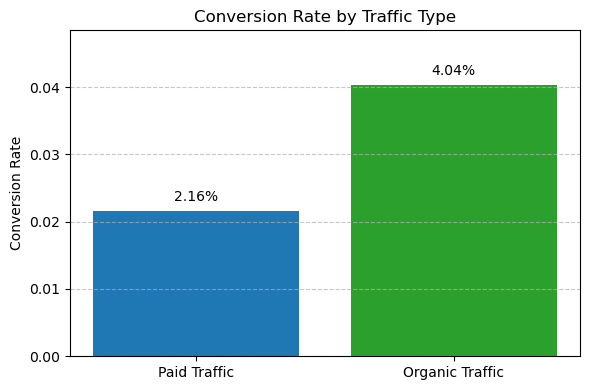

In [36]:
paid_conversion_rate = df_split['paid_is_target'].mean()
organic_conversion_rate = df_split['organic_is_target'].mean()

# Подготовка данных для графика
conversion_rates = [paid_conversion_rate, organic_conversion_rate]
labels = ['Paid Traffic', 'Organic Traffic']

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, conversion_rates, color=['#1f77b4', '#2ca02c'])

# Подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.title('Conversion Rate by Traffic Type')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

CR органического трафика почти в 2 раза выше. Платный трафик отличается от органического с точки зрения CR

## 2. Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события.

In [40]:
df_sessions['device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

In [42]:
# категории tablet и mobile объеденяем, т к в данном случае для нас это одно и то же

In [44]:
df_temp = df_combined.copy()

df_temp['device_group'] = df_temp['device_category'].apply(
    lambda x: 'desktop' if x in ['desktop'] else 'mobile')

In [45]:
cr_by_device_type = df_temp.groupby('device_group')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

cr_by_device_type['conversion_rate'] = cr_by_device_type['conversions'] / cr_by_device_type['total_sessions']
print(cr_by_device_type)

  device_group  conversions  total_sessions  conversion_rate
0      desktop        11513          366863         0.031382
1       mobile        38801         1493179         0.025985


In [205]:
#сделаем функцию, которая создает датафрейм для тестирования. Сравнивать будем CR по каждому календарному дню

In [48]:
def generate_df_for_ttest(df, attribute):

    df_all = df.groupby(['visit_date']).agg({'session_id': 'nunique'}).reset_index()

    df_true = df.loc[df[attribute] == True].groupby(['visit_date']).agg({'is_target': 'sum', 'session_id': 'nunique'}).reset_index()

    df_true['cr_true'] = 100 * df_true['is_target'] / df_true['session_id']

    df_true = df_true.drop(columns=['is_target', 'session_id'])

    

    df_false = df.loc[df[attribute] == False].groupby(['visit_date']).agg({'is_target': 'sum', 'session_id': 'nunique'}).reset_index()

    df_false['cr_false'] = 100 * df_false['is_target'] / df_false['session_id']

    df_false = df_false.drop(columns=['is_target', 'session_id'])

    

    df_all = df_all.merge(df_true, how='left', on='visit_date')

    df_all = df_all.merge(df_false, how='left', on='visit_date')

    df_all = df_all.drop(columns=['session_id']).reset_index(drop=True)

    return df_all

In [52]:
df_temp['is_mobile'] = df_temp['device_group'] == 'mobile'

In [54]:
df_mobile_dist = generate_df_for_ttest(df_temp, 'is_mobile')

In [207]:
#Проверим нормально ли распределены данные.

In [55]:
df_mobile_dist = df_mobile_dist.dropna(subset=['cr_true', 'cr_false'])

print("Kolmogorov-Smirnov Test:")
ks_stat, ks_p = kstest(df_mobile_dist['cr_true'], df_mobile_dist['cr_false'])
print(f"KS-тест: статистика = {ks_stat:.4f}, p-value = {ks_p:.4f}")

Kolmogorov-Smirnov Test:
KS-тест: статистика = 0.1062, p-value = 0.1564


In [211]:
#p > 0.05, распределение можно считать нормальным. Проверим дисперсии.

In [56]:
levene_stat, levene_p = stats.levene(df_mobile_dist['cr_true'], df_mobile_dist['cr_false'])

print(f"Тест Левена: статистика = {levene_stat:.4f}, p-value = {levene_p:.4f}")

Тест Левена: статистика = 20.7936, p-value = 0.0000


In [209]:
#Дисперсии отличаются. Проведем t-тест Уэлча

df_mobile_dist = df_mobile_dist.dropna(subset=['cr_true', 'cr_false'])

stat, p_value = stats.ttest_ind(df_mobile_dist['cr_true'], df_mobile_dist['cr_false'], equal_var=False)

print(f"Т-критерий Уэлча: t-статистика = {stat:.4f}, p-value = {p_value:.4f}")

Т-критерий Уэлча: t-статистика = -2.6606, p-value = 0.0081


Так как p-value = 0.0081 < 0.05, мы отвергаем нулевую гипотезу.

Это означает, что средние значения конверсий в группах cr_true и cr_false статистически различаются.

Для наглядности визуализируем данные.

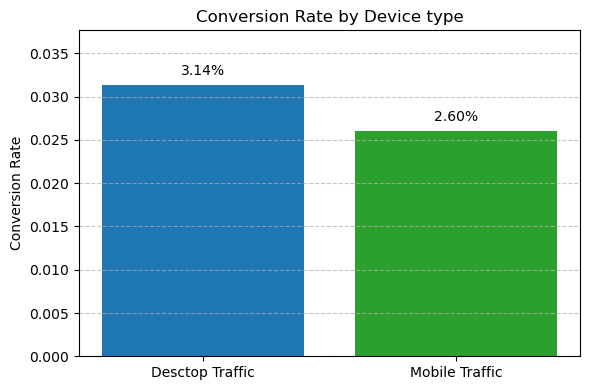

In [217]:
desc_conversion_rate = cr_by_device_type['conversion_rate'][0]
mob_conversion_rate = cr_by_device_type['conversion_rate'][1]

# Подготовка данных для графика
conversion_rates = [desc_conversion_rate, mob_conversion_rate]
labels = ['Desctop Traffic', 'Mobile Traffic']

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, conversion_rates, color=['#1f77b4', '#2ca02c'])

# Подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.title('Conversion Rate by Device type')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

## 3. Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события.

In [72]:
df_combined['geo_country'].value_counts(dropna=False)

geo_country
Russia                 1800565
United States            11784
Ukraine                   9012
Ireland                   4034
Belarus                   3636
                        ...   
Zambia                       1
Malawi                       1
Réunion                      1
Barbados                     1
Congo - Brazzaville          1
Name: count, Length: 166, dtype: int64

In [74]:
#Оставим для проверки гипотезы только Россию

In [76]:
df_russia = df_combined[df_combined['geo_country'] == 'Russia']

In [78]:
df_russia['geo_city'].value_counts(dropna=False)

geo_city
Moscow                        805329
Saint Petersburg              296788
(not set)                      70021
Yekaterinburg                  35788
Krasnodar                      32243
                               ...  
Menzelinsk                         1
Slavyanka                          1
Aleksandrovsk-Sakhalinskiy         1
9992                               1
Beslan                             1
Name: count, Length: 506, dtype: int64

In [80]:
df_rus = df_russia.copy()

df_rus['region_group'] = df_rus['geo_city'].apply(
    lambda x: 'Moscow_SpB' if x in ['Moscow', 'Saint Petersburg'] else 'Regions')

In [81]:
cr_by_region = df_rus.groupby('region_group')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

cr_by_region['conversion_rate'] = cr_by_region['conversions'] / cr_by_region['total_sessions']
print(cr_by_region)

  region_group  conversions  total_sessions  conversion_rate
0   Moscow_SpB        30742         1102117         0.027894
1      Regions        18414          698448         0.026364


In [82]:
df_rus['is_moscow'] = df_rus['region_group'] == 'Moscow_SpB'

In [85]:
df_region_dist = generate_df_for_ttest(df_rus, 'is_moscow')

In [87]:
df_region_dist = df_region_dist.dropna(subset=['cr_true', 'cr_false'])

print("Kolmogorov-Smirnov Test:")
ks_stat, ks_p = kstest(df_region_dist['cr_true'], df_region_dist['cr_false'])
print(f"KS-тест: статистика = {ks_stat:.4f}, p-value = {ks_p:.4f}")

Kolmogorov-Smirnov Test:
KS-тест: статистика = 0.1372, p-value = 0.0284


In [88]:
# Нулевая гипотеза (H0): Распределения конверсий (CR) у трафика из Москвы и Санкт-Петербурга и трафика из других регионов одинаковы.
# Альтернативная гипотеза (H1): Распределения конверсий различаются.

stat, p_value = stats.mannwhitneyu(df_region_dist['cr_true'], df_region_dist['cr_false'], alternative='two-sided')

print(f"Манна-Уитни: статистика = {stat:.4f}, p-value = {p_value:.4f}")

Манна-Уитни: статистика = 26428.0000, p-value = 0.5218


Так как p-value = 0.5218 > 0.05, мы не отвергаем нулевую гипотезу.

Это означает, что нет статистически значимых различий между группами cr_true и cr_false по сравнению с их распределениями.

Сделаем и здесь визуализацию.

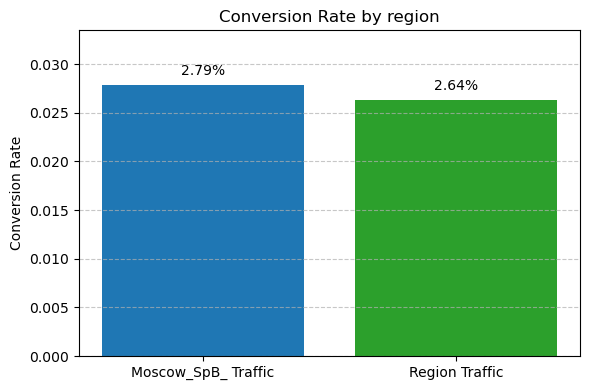

In [103]:
moscow_conversion_rate = cr_by_region['conversion_rate'][0]
region_conversion_rate = cr_by_region['conversion_rate'][1]

# Подготовка данных для графика
conversion_rates = [moscow_conversion_rate, region_conversion_rate]
labels = ['Moscow_SpB_ Traffic', 'Region Traffic']

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, conversion_rates, color=['#1f77b4', '#2ca02c'])

# Подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.title('Conversion Rate by region')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Ответы на вопросы продуктовой компании

## 1. Из каких источников (кампаний, устройств, локаций) к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?

In [95]:
#Брать к расчету CR данные будем те, где total_sessions более 3000

In [97]:
#Расчёт CR по кампаниям
cr_by_campaign = df_combined.groupby('utm_campaign')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()
filtered_cr_by_camp = cr_by_campaign[cr_by_campaign['total_sessions'] > 3000]
filtered_cr_by_camp['conversion_rate'] = filtered_cr_by_camp['conversions'] / filtered_cr_by_camp['total_sessions']

#Расчёт CR по устройствам (mobile, desktop, tablet)
cr_by_device = df_combined.groupby('device_category')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()
filtered_cr_by_device = cr_by_device[cr_by_device['total_sessions'] > 3000]
filtered_cr_by_device['conversion_rate'] = filtered_cr_by_device['conversions'] / filtered_cr_by_device['total_sessions']

#Расчёт CR по локациям (города России)
cr_by_location = df_combined.groupby('geo_city')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()
filtered_cr_by_location = cr_by_location[cr_by_location['total_sessions'] > 3000]
filtered_cr_by_location['conversion_rate'] = filtered_cr_by_location['conversions'] / filtered_cr_by_location['total_sessions']

C:\Users\derna\AppData\Local\Temp\ipykernel_12476\3611829325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cr_by_camp['conversion_rate'] = filtered_cr_by_camp['conversions'] / filtered_cr_by_camp['total_sessions']
C:\Users\derna\AppData\Local\Temp\ipykernel_12476\3611829325.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cr_by_location['conversion_rate'] = filtered_cr_by_location['conversions'] / filtered_cr_by_location['total_sessions']


In [182]:
top3_campaign_by_volume = cr_by_campaign.sort_values('total_sessions', ascending=False).head(3)
top3_device_by_volume = cr_by_device.sort_values('total_sessions', ascending=False).head(3)
top3_location_by_volume = cr_by_location.sort_values('total_sessions', ascending=False).head(3)

top3_campaign_by_cr = filtered_cr_by_camp.sort_values('conversion_rate', ascending=False).head(3)
top3_device_by_cr = filtered_cr_by_device.sort_values('conversion_rate', ascending=False).head(3)
top3_location_by_cr = filtered_cr_by_location.sort_values('conversion_rate', ascending=False).head(3)

In [185]:
print("🔥 Топ-3 источников с наибольшим объемом трафика (по total_sessions):")
print("_________________________")
print("🎯 Топ-3 по кампаниям:")
print(top3_campaign_by_volume[['utm_campaign', 'total_sessions']])
print("_________________________")
print("🎯 Топ-3 по устройствам:")
print(top3_device_by_volume[['device_category', 'total_sessions']])
print("_________________________")
print("🎯 Топ-3 по локациям:")
print(top3_location_by_volume[['geo_city', 'total_sessions']])

print("______________________________________________________")
print("\n🔥 Топ-3 источников с наибольшим Conversion Rate (CR):")
print("_________________________")
print("🎯 Топ-3 по кампаниям:")
print(top3_campaign_by_cr[['utm_campaign', 'conversion_rate']])
print("_________________________")
print("🎯 Топ-3 по устройствам:")
print(top3_device_by_cr[['device_category', 'conversion_rate']])
print("_________________________")
print("🎯 Топ-3 по локациям:")
print(top3_location_by_cr[['geo_city', 'conversion_rate']])

🔥 Топ-3 источников с наибольшим объемом трафика (по total_sessions):
_________________________
🎯 Топ-3 по кампаниям:
            utm_campaign  total_sessions
88  LTuZkdKfxRGVceoWkVyg          463481
85  LEoPHuyFvzoNfnzGgfcd          324044
40  FTjNLDyTrXaWYgZymFkV          247360
_________________________
🎯 Топ-3 по устройствам:
  device_category  total_sessions
1          mobile         1474871
0         desktop          366863
2          tablet           18308
_________________________
🎯 Топ-3 по локациям:
              geo_city  total_sessions
1434            Moscow          805329
1930  Saint Petersburg          296788
1            (not set)           78172
______________________________________________________

🔥 Топ-3 источников с наибольшим Conversion Rate (CR):
_________________________
🎯 Топ-3 по кампаниям:
             utm_campaign  conversion_rate
266  hkvDVxqLOzGjGaoNiNzN         0.041395
88   LTuZkdKfxRGVceoWkVyg         0.041007
50   HEimDfYZIzuQXDZAAcEW         0.034863


___Выводы:___

1. Топ-3 источников с наибольшим объёмом трафика (по total_sessions)
Кампании:

___LTuZkdKfxRGVceoWkVyg (463,481 сессий)___ — кампания с наибольшим количеством сессий, что означает, что она привлекла больше всего пользователей.

___LEoPHuyFvzoNfnzGgfcd (324,044 сессий)___ — следующая по величине кампания, которая также привлекла много пользователей.

___FTjNLDyTrXaWYgZymFkV (247,360 сессий)___ — ещё одна кампания с большим объёмом трафика.

Устройства:

___Mobile (1,474,871 сессий)___ — мобильные устройства составляют наибольшую часть трафика, что подтверждает общую тенденцию роста мобильного интернета.

___Desktop (366,863 сессий)___ — трафик с десктопных устройств значительно меньше, но всё ещё значителен.

___Tablet (18,308 сессий)___ — трафик с планшетов значительно меньше по сравнению с мобильными устройствами и десктопами.

Локации (города):

___Moscow (805 329 сессий)___ — Москва является крупнейшим источником трафика.

___Saint Petersburg (296 788 сессий)___ — трафик из СПБ намного меньше, чем из Москвы.

___(not set) (78172 сессий)___ — Сессий где город не определен достаточно много.

Выводы:

Мобильные устройства и Россия — главные источники трафика, что подтверждает тренд на мобильный интернет и высокую активность пользователей в России.

Кампании с большим объёмом трафика могут требовать больше внимания для оптимизации, так как они приводят к большому количеству сессий, но не обязательно приводят к большому числу конверсий.

2. Топ-3 источников с наибольшим Conversion Rate (CR)
1. Кампании

Кампания	Conversion Rate

___hkvDVxqLOzGjGaoNiNzN	4.14%___

___LTuZkdKfxRGVceoWkVyg	4.10%___

___HEimDfYZIzuQXDZAAcEW	3.49%___

Выводы:

Эти кампании показывают значительно более высокий CR, чем в среднем, особенно первая (более 4%).

Возможно, именно в этих кампаниях наиболее качественный трафик (релевантная аудитория, удачное предложение, эффективные креативы).

Рекомендуется проанализировать креативы, офферы и каналы этих кампаний и масштабировать лучшие практики.

2. Устройства

Устройство	Conversion Rate

___Desktop	3.14%___

___Mobile	2.60%___

___Tablet	2.31%___

Выводы:

Пользователи с десктопов совершают конверсии чаще, чем с мобильных устройств.

Возможные причины: удобство интерфейса, более осознанный выбор, доверие к сайту выше на десктопе.

Рекомендуется протестировать улучшения мобильной версии сайта (скорость загрузки, простота формы заявки и т.д.).

3. География

Город	Conversion Rate

___Domodedovo	6.51%___

___Stavropol	4.11%___

___Kazan	3.86%___

Выводы:

В Домодедово конверсия заметно выше остальных городов — это может быть связано с хорошим оффером, активной рекламной кампанией или специфическим спросом. (Вероятно это связано с аэропортом)

Рекомендуется глубже изучить характеристики трафика из этих городов: какие каналы приводят пользователей, какие авто чаще интересуют и т.д.

Эти регионы могут стать приоритетом при запуске новых кампаний.

## 2. Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

### Топ автомобилей по спросу

In [111]:
df_hits_reduced = df_hits[['session_id', 'hit_page_path']]

In [112]:
df_combined_reduced = df_combined[['session_id', 'is_target']]

In [113]:
df_combined_cars = df_combined_reduced.merge(df_hits_reduced, on='session_id', how='left')

In [221]:
cr_by_car = df_combined_cars.groupby('hit_page_path')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

top15_device_by_car = cr_by_car.sort_values('total_sessions', ascending=False).head(15)

print("🎯 Топ-15 автомобилей по спросу:")
print(top15_device_by_car[['hit_page_path', 'total_sessions']])

🎯 Топ-15 автомобилей по спросу:
                                            hit_page_path  total_sessions
3078                               podpiska.sberauto.com/         2790578
294893  sberauto.com/cars?city=1&rental_page=rental_on...         1103282
322943  sberauto.com/cars?utm_source_initial=sbol&utm_...          754215
272566  sberauto.com/cars/f28947a1?rental_page=rental_car          264878
247936  sberauto.com/cars/bf24b977?rental_page=rental_car          263966
322927  sberauto.com/cars?utm_source_initial=sbol&utm_...          257588
292857  sberauto.com/cars?city=1&city=18&rental_page=r...          198943
252286  sberauto.com/cars/bfc21661?rental_page=rental_car          187602
136405  sberauto.com/cars/2fc745ed?rental_page=rental_car          168381
220634  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...          168055
147878  sberauto.com/cars/7a3f9330?rental_page=rental_car          153775
264825  sberauto.com/cars/e994838f?rental_page=rental_car          150493
322963

In [119]:
# мы видим что нужные нам строки отобрaжаются по такой маске sberauto.com/cars/all/lada-vaz/vesta/2fc745ed
# покажем только значения которые начинаются с sberauto.com/cars/all/

In [121]:
filtered_df_cars = df_combined_cars[df_combined_cars['hit_page_path'].str.startswith('sberauto.com/cars/all/', na=False)]

In [122]:
cr_by_car_new = filtered_df_cars.groupby('hit_page_path')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

top15_device_by_car_new = cr_by_car_new.sort_values('total_sessions', ascending=False)

print("🎯 Топ-15 автомобилей по объему трафика:")
print(top15_device_by_car_new[['hit_page_path', 'total_sessions']].head(15))

🎯 Топ-15 автомобилей по объему трафика:
                                           hit_page_path  total_sessions
63690  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...          168055
14761  sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...          144094
76737  sberauto.com/cars/all/volkswagen/polo/e994838f...          114650
58264  sberauto.com/cars/all/skoda/karoq/94b3d18e?ren...           82026
21551  sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...           67571
71407  sberauto.com/cars/all/skoda/rapid/bf24b977?utm...           67218
26867  sberauto.com/cars/all/mercedes-benz/e-klasse/d...           61355
44131  sberauto.com/cars/all/nissan/qashqai/bfc21661?...           55670
71426  sberauto.com/cars/all/skoda/rapid/bf24b977?utm...           41630
81493  sberauto.com/cars/all/volkswagen/polo/e994838f...           40600
54764  sberauto.com/cars/all/renault/duster/145d53f1?...           37175
62099  sberauto.com/cars/all/skoda/octavia/4791c8b2?r...           34724
21540  sber

In [125]:
#сделаем понятную таблицу и просуммируем одни и те же машины, которые встречались по разным ссылкам.

In [127]:
def extract_car_brand_and_model(hit_page_path):
    match = re.search(r'sberauto\.com/cars/all/([^/]+)/([^/]+)', hit_page_path)
    if match:
        return f'{match.group(1)} {match.group(2)}'.lower()
    return 'unknown'
    
top15_device_by_car_new['car'] = top15_device_by_car_new['hit_page_path'].apply(extract_car_brand_and_model)

# Группируем по 'car' и суммируем total_sessions
result_grouped = (
    top15_device_by_car_new
    .groupby('car', as_index=False)['total_sessions']
    .sum()
    .sort_values('total_sessions', ascending=False)
)

result_grouped = result_grouped.reset_index(drop=True)
result_grouped.index += 1

___Топ 15 автомобилей по объему спроса:___

In [140]:
result_grouped.head(15)

,car,total_sessions
1,skoda rapid,438809
2,lada-vaz vesta,398717
3,volkswagen polo,313809
4,skoda karoq,193723
5,mercedes-benz e-klasse,177954
6,nissan qashqai,149926
7,kia rio,89767
8,nissan x-trail,83152
9,skoda octavia,76910
10,renault duster,75375


### Далее Топ машин по CR

In [148]:
cr_by_specific_cars = filtered_df_cars.groupby('hit_page_path')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

cr_by_specific_cars['conversion_rate'] = cr_by_specific_cars['conversions'] / cr_by_specific_cars['total_sessions']

In [150]:
top15_cars = cr_by_specific_cars.sort_values('conversion_rate', ascending=False).head(10)

print(top15_cars[['hit_page_path', 'total_sessions', 'conversion_rate']])

                                           hit_page_path  total_sessions  \
43466  sberauto.com/cars/all/mini/hatch/b82590a3?utm_...               7   
66581  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...               9   
34686  sberauto.com/cars/all/mercedes-benz/g-klasse/e...               7   
66859  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...               7   
66841  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...               9   
66786  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...              27   
66779  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...              16   
66769  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...               8   
66737  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...               7   
66725  sberauto.com/cars/all/skoda/rapid/bf24b977?ren...              16   

       conversion_rate  
43466              1.0  
66581              1.0  
34686              1.0  
66859              1.0  
66841              1.0  
66786        

In [152]:
# Очевидно, эти данные нам никакой пользы не несут.
# Оценим данные, где total_sessions более 2000

In [154]:
cr_by_specific_cars_upd = filtered_df_cars.groupby('hit_page_path')['is_target'].agg(
    conversions='sum',
    total_sessions='count'
).reset_index()

filtered_cr_by_specific_cars = cr_by_specific_cars_upd[cr_by_specific_cars_upd['total_sessions'] > 2000]

filtered_cr_by_specific_cars['conversion_rate'] = filtered_cr_by_specific_cars['conversions'] / filtered_cr_by_specific_cars['total_sessions']

top15_cars = filtered_cr_by_specific_cars.sort_values('conversion_rate', ascending=False).head(15)

print(top15_cars[['hit_page_path', 'total_sessions', 'conversion_rate']])

                                           hit_page_path  total_sessions  \
10777  sberauto.com/cars/all/kia/rio/fee33fe6?utm_sou...            2003   
71436  sberauto.com/cars/all/skoda/rapid/bf24b977?utm...            2537   
74376  sberauto.com/cars/all/toyota/camry/f28947a1?ut...            3543   
74380  sberauto.com/cars/all/toyota/camry/f28947a1?ut...           10706   
81514  sberauto.com/cars/all/volkswagen/polo/e994838f...            7542   
10757  sberauto.com/cars/all/kia/rio/fee33fe6?utm_sou...            5645   
74385  sberauto.com/cars/all/toyota/camry/f28947a1?ut...            2849   
63105  sberauto.com/cars/all/skoda/octavia/4791c8b2?u...            8553   
57903  sberauto.com/cars/all/renault/logan/8c3c73f2?u...            2115   
10762  sberauto.com/cars/all/kia/rio/fee33fe6?utm_sou...           17520   
71435  sberauto.com/cars/all/skoda/rapid/bf24b977?utm...            2053   
81487  sberauto.com/cars/all/volkswagen/polo/e994838f...           14394   
10767  sbera

C:\Users\derna\AppData\Local\Temp\ipykernel_12476\634010680.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cr_by_specific_cars['conversion_rate'] = filtered_cr_by_specific_cars['conversions'] / filtered_cr_by_specific_cars['total_sessions']


In [156]:
filtered_cr_by_specific_cars['car'] = filtered_cr_by_specific_cars['hit_page_path'].apply(extract_car_brand_and_model)

grouped_cr = (
    filtered_cr_by_specific_cars
    .groupby('car', as_index=False)[['conversions', 'total_sessions']]
    .sum()
)

grouped_cr['conversion_rate'] = grouped_cr['conversions'] / grouped_cr['total_sessions']

top_cr = grouped_cr.sort_values('conversion_rate', ascending=False)

top_cr = top_cr.reset_index(drop=True)
top_cr.index += 1

C:\Users\derna\AppData\Local\Temp\ipykernel_12476\2342063049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cr_by_specific_cars['car'] = filtered_cr_by_specific_cars['hit_page_path'].apply(extract_car_brand_and_model)


___Топ-15 автомобилей по CR___

In [223]:
top_cr[['car', 'conversion_rate']].head(15)

,car,conversion_rate
1,kia rio,0.148872
2,hyundai solaris,0.144151
3,toyota camry,0.141512
4,volkswagen polo,0.120749
5,lada-vaz vesta,0.115349
6,toyota corolla,0.115211
7,kia seltos,0.112168
8,skoda octavia,0.111648
9,skoda rapid,0.110191
10,haval jolion,0.107015


### Общий ТОП автомобилей

Сделаем общий ТОП, т. е. автомобили, которые попали в топ-15 и по total_sessions и по CR. Отсортируем список по значению CR.

In [177]:
result_grouped_top15 = result_grouped.head(15)
top_cr15 = top_cr[['car', 'total_sessions', 'conversion_rate']].head(15)

In [200]:
#Сделаем inner_join по car и получим общий ТОП автомобилей.
merged_df = pd.merge(
    top_cr15[['car', 'conversion_rate']],
    result_grouped_top15[['car', 'total_sessions']],
    on='car',
    how='inner'
)

# Сортировка по total_sessions
final_df = merged_df.sort_values(by='conversion_rate', ascending=False).reset_index(drop=True)

final_df.index = final_df.index + 1

final_df

,car,conversion_rate,total_sessions
1,kia rio,0.148872,89767
2,toyota camry,0.141512,72960
3,volkswagen polo,0.120749,313809
4,lada-vaz vesta,0.115349,398717
5,kia seltos,0.112168,70042
6,skoda octavia,0.111648,76910
7,skoda rapid,0.110191,438809
8,renault logan,0.103077,71848
9,kia sorento,0.087912,69794


## 3. Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

Да, **увеличивать присутствие в соцсетях и усиливать рекламную активность** — **оправданное решение**, но с важными уточнениями:

---

###  **Почему стоит усиливать продвижение в соцсетях:**

1. Посмотрим на график разделения пользователей по типу устройств.

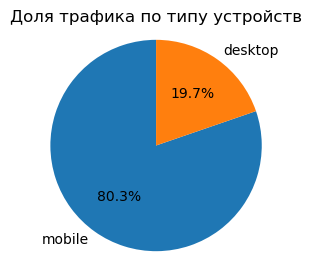

In [244]:
device_counts = df_temp['device_group'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Доля трафика по типу устройств')
plt.axis('equal')
plt.show()

**Мобильный трафик — доминирующий (≈80%)**, а пользователи соцсетей в основном приходят именно с мобильных устройств. Это хорошо сочетается с текущей аудиторией.

2. Сделаем график лучших рекламных кампаний, и посмотрим на CR

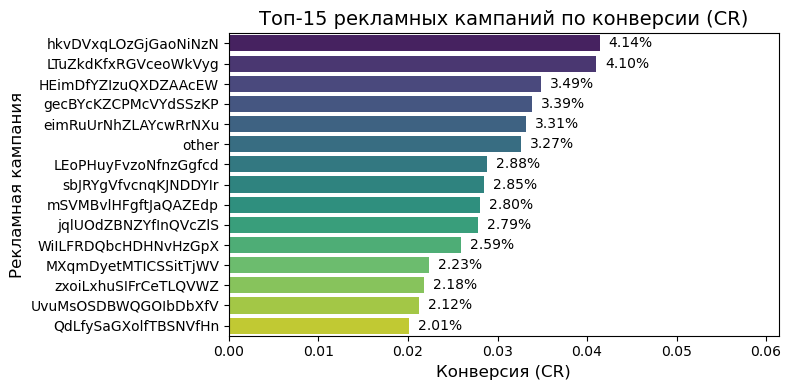

In [246]:
top_campaigns = filtered_cr_by_camp.sort_values('conversion_rate', ascending=False).head(15)

plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data=top_campaigns,
    x='conversion_rate',
    y='utm_campaign',
    hue='utm_campaign',
    dodge=False,
    legend=False,
    palette='viridis'
)

for i, row in enumerate(top_campaigns.itertuples()):
    plt.text(
        row.conversion_rate + 0.001,
        i,
        f"{row.conversion_rate * 100:.2f}%",
        va='center',
        fontsize=10
    )

plt.title('Топ-15 рекламных кампаний по конверсии (CR)', fontsize=14)
plt.xlabel('Конверсия (CR)', fontsize=12)
plt.ylabel('Рекламная кампания', fontsize=12)
plt.xlim(0, top_campaigns['conversion_rate'].max() + 0.02)
plt.tight_layout()

plt.show()

**Успешные кампании уже дают высокий CR (4%+)**, а значит, при правильной настройке и таргетинге в соцсетях можно получить не только объём, но и качество.

3. Сделаем график лучших городов с точки зрения CR

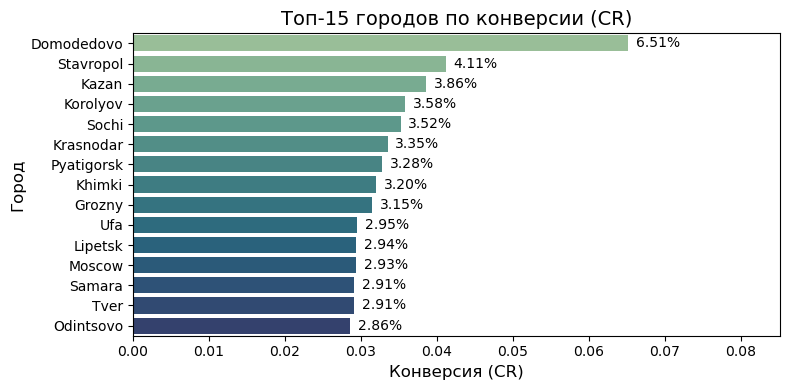

In [187]:
top_locations = filtered_cr_by_location.sort_values('conversion_rate', ascending=False).head(15)

# График
plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data=top_locations,
    x='conversion_rate',
    y='geo_city',
    hue='geo_city',
    dodge=False,
    legend=False,
    palette='crest'
)

# Подписи на полосах
for i, row in enumerate(top_locations.itertuples()):
    plt.text(
        row.conversion_rate + 0.001,
        i,
        f"{row.conversion_rate * 100:.2f}%",
        va='center',
        fontsize=10
    )

# Оформление
plt.title('Топ-15 городов по конверсии (CR)', fontsize=14)
plt.xlabel('Конверсия (CR)', fontsize=12)
plt.ylabel('Город', fontsize=12)
plt.xlim(0, top_locations['conversion_rate'].max() + 0.02)
plt.tight_layout()

plt.show()

**Регионы с высокой конверсией (например, Домодедово, Казань)** — хороший ориентир для локального таргетинга в соцсетях. Такие сегменты можно усиленно прорабатывать.

4. **Аналитика уже даёт понимание успешных креативов и офферов** — можно использовать их в рекламных форматах соцсетей (видео, карусели, сторис и т.д.).

###  **На что стоит обратить внимание перед масштабированием:**

Посмотрим на график CR по категориям устройств

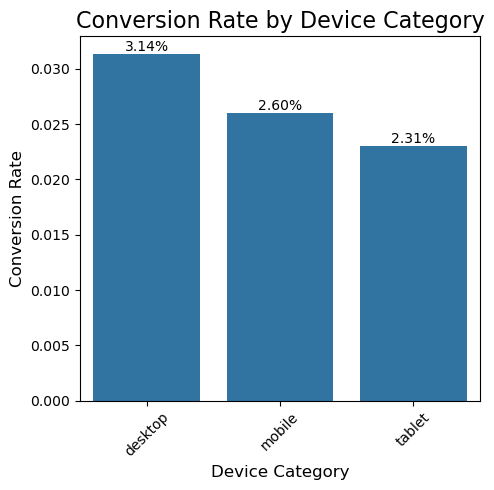

In [195]:
plt.figure(figsize=(5, 5))
barplot = sns.barplot(
    data=filtered_cr_by_device,
    x='device_category',
    y='conversion_rate'
)

barplot.bar_label(
    barplot.containers[0],
    labels=[f'{height*100:.2f}%' for height in [p.get_height() for p in barplot.patches]],
    fontsize=10
)

plt.title('Conversion Rate by Device Category', fontsize=16)
plt.xlabel('Device Category', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- **Проверьте эффективность мобильной версии сайта** — пользователи соцсетей часто заходят именно с телефона, а CR там ниже. Улучшение мобильного UX может сильно повлиять на итоговые метрики.

- **Отслеживайте не только трафик, но и CR новых кампаний** — большие объёмы не всегда значат эффективность. Продолжайте опираться на CR, а не только на клики.

- **А/B тестируйте креативы и посылы** — то, что работает в поиске или контексте, не всегда работает в соцсетях.

###  Итог:
**Да, стоит.** Но делать это **точечно** — усиливать рекламную активность в соцсетях с опорой на:
- наиболее конверсионные кампании,
- мобильную аудиторию,
- эффективные города и офферы,
- постоянную аналитику CR и стоимости заявки (CPL).